In [1]:
! pip install stable-baselines3[extra]
! pip install yfinance

     |████████████████████████████████| 153kB 2.1MB/s 
     |████████████████████████████████| 6.3MB 3.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=162ff5a018bf1019c4e36c58b721e2424898fe3e3385b12a1fa9a8a3d404622f
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3729    0  3729    0     0   3414      0 --:--:--  0:00:01 --:--:--  3414
100  503k  100  503k    0     0   177k      0  0:00:02  0:00:02 --:--:--  655k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3757    0  3757    0     0   3485      0 --:--:--  0:00:01 --:--:--  3485
100  406k  100  406k    0     0   149k      0  0:00:02  0:00:02 --:--:--  281k


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import yfinance as yf

In [4]:
import gym
from gym import spaces

# Data loading

In [5]:
INIT_NET_WORTH = 10000
WINDOW = 10
ROLLING = 126

In [20]:
TICKER = 'SPY'

if TICKER == 'COSINE':
    df = pd.DataFrame({
        'High': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.01, size = (2000, )),
        'Open': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.01, size = (2000, )),
        'Close': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.01, size = (2000, )),
        'Low': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.01, size = (2000, )),
        'Volume': np.abs(np.sin(np.arange(2000)/100.0)),
      }
      )
else:
    df = yf.download(TICKER, start="2000-01-01", end="2011-01-01")

[*********************100%***********************]  1 of 1 completed


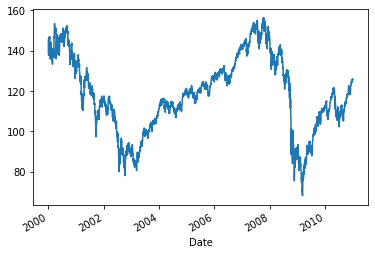

In [21]:
df['Close'].plot()

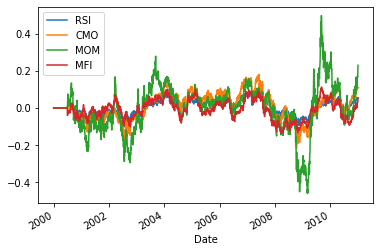

In [22]:
pd.DataFrame(
            {
                'RSI': ((talib.RSI(df['Close'], timeperiod=ROLLING).to_frame().fillna(50.0) - 50) / 100).values.flatten(),
                'CMO': ((talib.CMO(df['Close'], timeperiod=ROLLING).to_frame().fillna(0.0)) / 100).values.flatten(),
                'MOM': df['Close'].pct_change(ROLLING).to_frame().fillna(0.0).values.flatten(),
                'MFI': ((talib.MFI(df['High'], df['Low'], df['Close'], df['Volume'], timeperiod=ROLLING) - 50) / 100).fillna(0.0).values.flatten()
            }, index = df.index
        ).plot()

# Environment

In [23]:
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv

In [24]:
class StockTradingEnv(gym.Env):

    def __init__(self, df, init_account_balance, window_shape, random_start = False):
        # initialize environment
        super(StockTradingEnv, self).__init__()
        # raw dataset
        self.df = df
        # how much $ do we have?
        self.init_account_balance = init_account_balance
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.window_shape = window_shape
        self.action_space = spaces.Discrete(2)
        self.random_start = random_start

        # current step, starts with window size or random
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)

        # process data initially
        self.process_data()

        # share costs
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance  
        if not self.random_start:
            self.current_step = self.window_shape
        else:
            self.current_step = random.randint(self.window_shape, len(self.df) - self.window_shape)
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0
        return self.get_observation()

    def process_data(self):
        self.start, self.end = self.window_shape, len(self.df)
        self.prices = self.df.iloc[self.start:self.end]
        # self.signal_features = self.df[['Open', 'Close', 'High', 'Low']].pct_change().fillna(0.0).iloc[self.start:self.end] 
        # self.signal_features = self.df[['Close']].pct_change().fillna(0.0).iloc[self.start:self.end]   

        self.signal_features = pd.DataFrame(
            {
                'RSI': ((talib.RSI(self.df['Close'], timeperiod=ROLLING).to_frame().fillna(50.0) - 50) / 100).values.flatten(),
                'CMO': ((talib.CMO(self.df['Close'], timeperiod=ROLLING).to_frame().fillna(0.0)) / 100).values.flatten(),
                'MOM': self.df['Close'].pct_change(ROLLING).to_frame().fillna(0.0).values.flatten(),
                'MFI': ((talib.MFI(self.df['High'], self.df['Low'], self.df['Close'], self.df['Volume'], timeperiod=ROLLING) - 50) / 100).fillna(0.0).values.flatten()
            }, 
            index = self.df.index).iloc[self.start:self.end]
        
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=(self.window_shape, self.signal_features.shape[-1]), dtype=np.float16
        )

    def get_observation(self):
        market_state = self.signal_features.iloc[self.current_step-self.window_shape:self.current_step]
        return market_state

    def step(self, action):
        self.take_action(action)
        self.current_step += 1

        if self.current_step > len(self.df) - self.window_shape:
            self.current_step = self.window_shape

        reward = self.net_worth

        done = False
        if (self.net_worth <= 0) or (self.current_step >= (len(self.df) - self.window_shape)):
            done = True

        obs = self.get_observation()
        return obs, reward, done, {}

    def take_action(self, action):

        # Set the current price to a random price within the time step
        current_price = random.uniform(
              self.df.iloc[self.current_step]["Open"],
              self.df.iloc[self.current_step]["Close"]
          )

        if not self.in_position:
            if action == 1: # OPEN LONG
                self.in_position = True
                self.price_bought = current_price
                self.bet_bought = self.balance
                self.balance -= self.bet_bought
                self.position_value = self.bet_bought
            else: # KEEP LOOKING
                pass
        else:
            market_return = ((current_price - self.price_bought) / self.price_bought)
            if action == 1: # HOLD LONG
                self.position_value = self.bet_bought * (1.0 + market_return)
            else: # CLOSE LONG
                self.balance += self.bet_bought * (1.0 + market_return)
                self.in_position = False
                self.price_bought = 0.0
                self.bet_bought = 0.0
                self.position_value = 0.0                

        self.net_worth = self.balance + self.position_value

    def render(self, mode='human'):
        return {
            'step': self.current_step,
            'balance': self.balance,
            'position': self.position_value,
            'net_worth': self.net_worth,
            'profit': self.net_worth - self.init_account_balance
        }

In [25]:
N_TIME_STEPS = len(df) - WINDOW
LR = 0.001
RANDOM_SEED = 11111

In [26]:
# The algorithms require a vectorized environment to run
env_train = DummyVecEnv([lambda: StockTradingEnv(df, INIT_NET_WORTH, WINDOW)])
env_train_viz = DummyVecEnv([lambda: StockTradingEnv(df, INIT_NET_WORTH, WINDOW)])
model = A2C('MlpPolicy', env_train, verbose=1, learning_rate=LR, seed=RANDOM_SEED)
model.learn(total_timesteps=N_TIME_STEPS, log_interval=100)

Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 281      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | -1.8e-05 |
|    learning_rate      | 0.001    |
|    n_updates          | 99       |
|    policy_loss        | 1.64e+04 |
|    value_loss         | 6.69e+08 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 276      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | 9.18e-06 |
|    learning_rate      | 0.001    |
|    n_updates          | 199      |
|    policy_loss        | 1.28e+04 |
|    value_loss     

# In-sample evaluation

In [27]:
def evaluate_agent(env, df, model):
    obs = env.reset()
    history = {
        'balance': [],
        'action': [],
        'position': [],
        'net_worth': []
    }

    for i in range(len(df) - WINDOW):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        if done[0] == True:
            break
        state = env.render()
        history['action'].append(action)
        history['balance'].append(state['balance'])
        history['net_worth'].append(state['net_worth'])
        history['position'].append(state['position'])

    actions_over_time = np.array(history['action'])
    return history, actions_over_time

In [28]:
history, actions_over_time = evaluate_agent(env_train_viz, df, model)

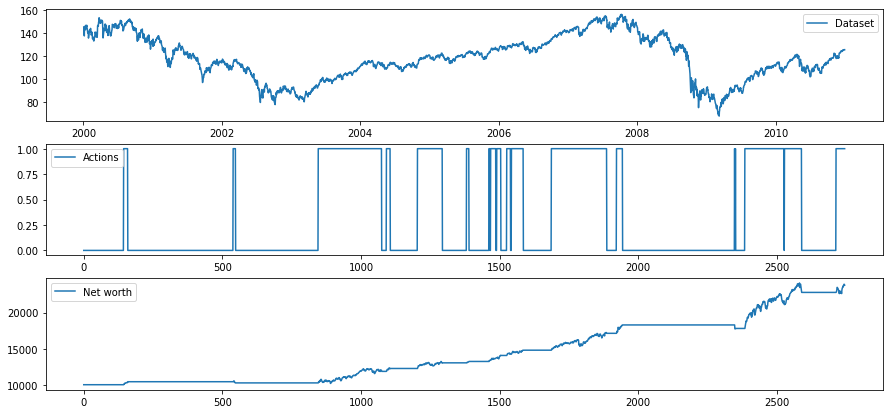

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
ax1.plot(df['Close'], label = 'Dataset')
ax2.plot(actions_over_time.flatten(), label = 'Actions')
ax3.plot(np.array(history['net_worth']), label = 'Net worth')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

# Evaluation single holdout out-of-sample

In [30]:
if TICKER == 'COSINE':
    df_test = pd.DataFrame({
        'High': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.02, size = (2000, )),
        'Open': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.02, size = (2000, )),
        'Close': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.02, size = (2000, )),
        'Low': np.sin(np.arange(2000)/100.0) + np.random.normal(2, 0.02, size = (2000, )),
        'Volume': np.abs(np.sin(np.arange(2000)/100.0)),
      }
      )
else:
    df_test = yf.download(TICKER, start="2011-01-01", end="2021-07-01")

[*********************100%***********************]  1 of 1 completed


In [31]:
env_test = DummyVecEnv([lambda: StockTradingEnv(df_test, INIT_NET_WORTH, WINDOW)])

In [32]:
history_test, actions_over_time_test = evaluate_agent(env_test, df_test, model)

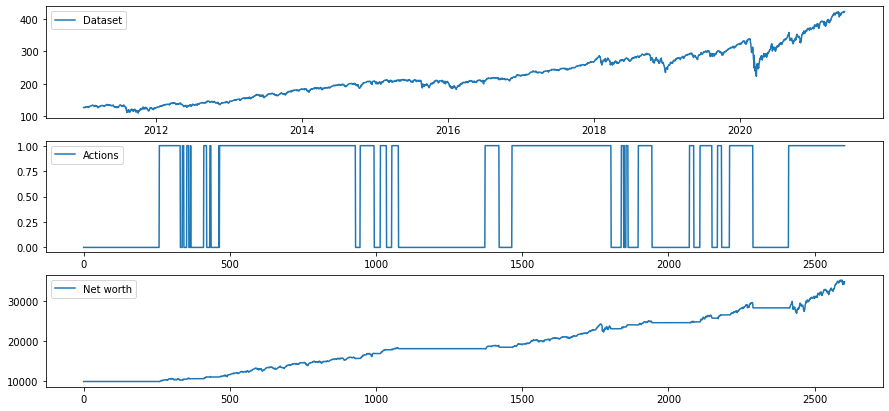

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
ax1.plot(df_test['Close'], label = 'Dataset')
ax2.plot(actions_over_time_test.flatten(), label = 'Actions')
ax3.plot(np.array(history_test['net_worth']), label = 'Net worth')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()